# OP Forecast — **V3.1: Total Base+Residual + LC Share**
패치: LC share 예측 시 `np.log`에서 발생하던 **TypeError**를 해결
- 관측 share 사용 경로에서 **`.astype(float).to_numpy()`**로 강제 float 변환 후 **`np.clip` → `np.log`**
- `compute_lc_share()`가 **숫자 강제 변환 + 재정규화**하도록 보강
나머지 파이프라인은 v3와 동일합니다.

In [1]:
# 공통 셋업
import os, warnings, random, json, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

warnings.simplefilter("ignore")
BASE_DIR = r"C:/ai/5차검증"; os.makedirs(BASE_DIR, exist_ok=True)
RANDOM_STATE = 42; np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)
CSV_ENCODING = "utf-8-sig"; plt.rcParams["figure.dpi"] = 120
def pjoin(name): return os.path.join(BASE_DIR, name)
def log(msg): print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {msg}")

In [2]:
# 경로
TRAIN_FILE = "train_data_encoded_final_2.csv"
PRED_FILE  = "predict_data_encoded_3.csv"
OUT_MONTHLY_SUMMARY = "월별_통합_결과.csv"
OUT_MONTHLY_FULL    = "월별_전체_결과.csv"
OUT_LC_2025         = "월별_LC별_결과_2025.csv"
OUT_FI_CSV          = "feature_importance.csv"
OUT_FI_PNG          = "feature_importance.png"
OUT_EVAL_CSV        = "model_eval.csv"
OUT_META_JSON       = "metadata.json"
OUT_PLOT_SV         = "plot_sales_volume.png"
OUT_PLOT_NS         = "plot_net_sales.png"
OUT_PLOT_OP         = "plot_operating_profit.png"

In [3]:
# 데이터 로드/검증
req_cols = [
    "date","sales_volume","raw_material","net_sales","operating_profit",
    "manufacturing_cost_var","sales_cost_var",
    "manufacturing_cost_fix","sales_cost_fix","maintenance_cost_fix"
]
species = ["chicken","cow","fish","swine"]; linkage = ["linked","unlinked"]
lc_cols = [f"lc_{s}_{l}" for s in species for l in linkage]

def ensure_columns(df, cols, fill=0.0):
    for c in cols:
        if c not in df.columns:
            log(f"Warning: missing column '{c}' -> create with {fill}")
            df[c] = fill
    return df

def to_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    return pd.to_datetime(s.dt.to_period("M").astype(str) + "-01")

train = pd.read_csv(pjoin(TRAIN_FILE), encoding="utf-8", low_memory=False)
pred  = pd.read_csv(pjoin(PRED_FILE),  encoding="utf-8", low_memory=False)
for df in (train, pred): df["date"] = to_month_start(df["date"])

train = train[(train["date"]>="2020-01-01") & (train["date"]<="2024-12-31")].copy()
pred  = pred[(pred["date"]>="2025-01-01")  & (pred["date"]<="2025-12-31")].copy()
train = ensure_columns(train, req_cols + lc_cols, 0.0).fillna(0.0)
pred  = ensure_columns(pred,  req_cols + lc_cols, 0.0).fillna(0.0)
log(f"train rows={len(train)}, pred rows={len(pred)}")
display(train.head(12)); display(pred.head(12))

[2025-09-03 09:29:52] train rows=480, pred rows=96


,date,operating_profit,sales_volume,net_sales,raw_material,manufacturing_cost_fix,manufacturing_cost_var,sales_cost_fix,sales_cost_var,maintenance_cost_fix,lc_chicken_linked,lc_chicken_unlinked,lc_cow_linked,lc_cow_unlinked,lc_fish_linked,lc_fish_unlinked,lc_swine_linked,lc_swine_unlinked
0,2020-01-01,62427285,16634110.0,7091870632,5887965191,290291248,117352350,173066135,462573740,98194683,0,0,0,0,0,0,1,0
1,2020-02-01,18349192,15096985.0,6451440795,5368061419,252314998,111047377,170449960,416858212,114359637,0,0,0,0,0,0,1,0
2,2020-03-01,37122401,15809670.0,6791069937,5642105649,283652973,96178360,157531311,387365752,187113491,0,0,0,0,0,0,1,0
3,2020-04-01,90392434,14496640.0,6405646250,5304892689,241117144,93355634,148630015,412014461,115243873,0,0,0,0,0,0,1,0
4,2020-05-01,169664012,14582105.0,6580981439,5471883807,244299348,87640113,154589298,372421260,80483601,0,0,0,0,0,0,1,0
5,2020-06-01,49362874,13047375.0,5964197407,4960764167,232088725,70887812,141085747,348151335,161856747,0,0,0,0,0,0,1,0
6,2020-07-01,170166596,14054095.0,6371832606,5308931493,222881027,72076084,149302631,369940018,78534757,0,0,0,0,0,0,1,0
7,2020-08-01,-68419556,12704535.0,5682462316,4854411353,230351545,78719296,152427192,332819857,102152629,0,0,0,0,0,0,1,0
8,2020-09-01,-8870928,14826315.0,6573844071,5544186520,248884835,76818022,155805154,379314328,177706140,0,0,0,0,0,0,1,0
9,2020-10-01,31240872,14813645.0,6329905286,5335360609,252972491,82972875,156606255,366961074,103791110,0,0,0,0,0,0,1,0


,date,operating_profit,sales_volume,net_sales,raw_material,manufacturing_cost_fix,manufacturing_cost_var,sales_cost_fix,sales_cost_var,maintenance_cost_fix,lc_chicken_linked,lc_chicken_unlinked,lc_cow_linked,lc_cow_unlinked,lc_fish_linked,lc_fish_unlinked,lc_swine_linked,lc_swine_unlinked
0,2025-01-01,108035956.0,11171380,0.0,5.518149e+09,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0
1,2025-02-01,125758894.0,9952785,0.0,4.998106e+09,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0
2,2025-03-01,-73349504.0,9525985,0.0,4.816844e+09,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0
3,2025-04-01,26725138.0,9859260,0.0,4.954881e+09,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0
4,2025-05-01,21762151.0,9893100,0.0,5.087910e+09,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0
5,2025-06-01,-184946584.0,8951575,0.0,4.653710e+09,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0
6,2025-07-01,-155117264.0,10194575,0.0,5.287779e+09,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0
7,2025-08-01,0.0,9889939,0.0,4.924720e+09,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0
8,2025-09-01,0.0,10536017,0.0,5.191447e+09,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0
9,2025-10-01,0.0,10802474,0.0,5.192943e+09,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0


In [4]:
# 파생 변수
def safe_unit(num, den):
    num = pd.to_numeric(num, errors="coerce").fillna(0.0)
    den = pd.to_numeric(den, errors="coerce").fillna(0.0)
    return pd.Series(np.where(den>0, num/den, 0.0), index=num.index)

def add_derived(df):
    df["price_per_unit"]        = safe_unit(df["net_sales"], df["sales_volume"])
    df["raw_material_per_unit"] = safe_unit(df["raw_material"], df["sales_volume"])
    df["mfg_cost_var_unit"]     = safe_unit(df["manufacturing_cost_var"], df["sales_volume"])
    df["sales_cost_var_unit"]   = safe_unit(df["sales_cost_var"], df["sales_volume"])
    linked_cols   = [c for c in df.columns if c.startswith("lc_") and c.endswith("_linked")]
    unlinked_cols = [c for c in df.columns if c.startswith("lc_") and c.endswith("_unlinked")]
    df["_linked_sum"]   = pd.to_numeric(df[linked_cols].sum(axis=1), errors="coerce").fillna(0.0) if linked_cols else 0.0
    df["_unlinked_sum"] = pd.to_numeric(df[unlinked_cols].sum(axis=1), errors="coerce").fillna(0.0) if unlinked_cols else 0.0
    denom = df["_linked_sum"] + df["_unlinked_sum"]
    df["linked_share"] = np.where(denom>0, df["_linked_sum"]/denom, 0.0).clip(0,1)
    df["month"]   = df["date"].dt.month.astype(int)
    df["quarter"] = df["date"].dt.quarter.astype(int)
    df["month_sin"] = np.sin(2*np.pi*df["month"]/12.0)
    df["month_cos"] = np.cos(2*np.pi*df["month"]/12.0)
    return df

train = add_derived(train); pred = add_derived(pred)
median_linked_share = float(train["linked_share"].median()) if len(train)>0 else 0.5
train["regime"] = np.where(train["linked_share"]>=median_linked_share, 1, 0)
pred["regime"]  = np.where(pred["linked_share"]>=median_linked_share, 1, 0)

def add_lag_roll(df_all, cols, max_lag=3, roll_win=3):
    df_all = df_all.sort_values("date").copy()
    for c in cols:
        for L in range(1, max_lag+1):
            df_all[f"{c}_lag{L}"] = df_all[c].shift(L)
        df_all[f"{c}_roll3"] = df_all[c].rolling(3).mean()
    return df_all

both = pd.concat([train, pred], ignore_index=True)
both = add_lag_roll(both, ["price_per_unit","raw_material_per_unit"], max_lag=3, roll_win=3)
train = both.iloc[:len(train)].fillna(0.0); pred  = both.iloc[len(train):].fillna(0.0)
for df in (train, pred): df["spread_price_raw"] = df["price_per_unit"] - df["raw_material_per_unit"]

In [5]:
# 가중치/지표
def months_diff(a, b): return (a.year*12 + a.month) - (b.year*12 + b.month)
def make_time_weights(dates, half_life_months=12, min_w=0.10):
    dates = pd.to_datetime(dates); last = dates.max()
    deltas = dates.apply(lambda d: months_diff(last, d)).astype(float)
    w = np.power(0.5, deltas / float(half_life_months)); w = np.maximum(w, min_w)
    return w * (len(w)/np.sum(w))
def W_MAE(y, yhat, dates, h): w = make_time_weights(dates, h, 0.10); return float(np.sum(w*np.abs(y-yhat))/np.sum(w))
def W_RMSE(y, yhat, dates, h): w = make_time_weights(dates, h, 0.10); return float(np.sqrt(np.sum(w*(y-yhat)**2)/np.sum(w)))

In [6]:
# Stage1A — 순매출 단가(corefix)
time_cols = ["month","quarter","month_sin","month_cos"]
lag_cols  = [f"{c}_lag{i}" for c in ["price_per_unit","raw_material_per_unit"] for i in range(1,4)] + \
            [f"{c}_roll3" for c in ["price_per_unit","raw_material_per_unit"]]

train["rm_x_linked"] = train["raw_material_per_unit"]*train["linked_share"]
pred["rm_x_linked"]  = pred["raw_material_per_unit"]*pred["linked_share"]
X_cols_s1a = ["raw_material_per_unit","linked_share","rm_x_linked"] + time_cols + lag_cols + [c for c in train.columns if c.startswith("lc_")]

y_ppu = train["price_per_unit"].values; w_s1a = make_time_weights(train["date"], 12, 0.10)
model_s1a = xgb.XGBRegressor(n_estimators=700, learning_rate=0.05, max_depth=4, subsample=0.9, colsample_bytree=0.9,
                             objective="reg:squarederror", random_state=42, n_jobs=0)
model_s1a.fit(train[X_cols_s1a].values, y_ppu, sample_weight=w_s1a)

def compute_bands(train_df, actual_col, by=("regime","month"), eps_ratio=0.10):
    g = train_df.groupby(list(by), dropna=False)[actual_col]
    band = g.quantile([0.10,0.90]).unstack().rename(columns={0.10:"p10",0.90:"p90"}).reset_index()
    band["iqr"] = (band["p90"]-band["p10"]).fillna(0.0); band["eps"] = (band["iqr"]*eps_ratio).fillna(0.0)
    band["lo"]  = (band["p10"]-band["eps"]).astype(float); band["hi"] = (band["p90"]+band["eps"]).astype(float)
    p10, p90 = float(train_df[actual_col].quantile(0.10)), float(train_df[actual_col].quantile(0.90))
    iqr = p90-p10; band["_g_lo"] = p10-iqr*eps_ratio; band["_g_hi"] = p90+iqr*eps_ratio
    return band

def apply_clip(df_context, pred_vals, bands, by=("regime","month")):
    tmp = df_context[list(by)].merge(bands, on=list(by), how="left")
    g_lo = bands["_g_lo"].iloc[0] if len(bands)>0 else float(np.nanmin(pred_vals))
    g_hi = bands["_g_hi"].iloc[0] if len(bands)>0 else float(np.nanmax(pred_vals))
    lo = np.maximum(tmp["lo"].fillna(g_lo).values, 0.0); hi = tmp["hi"].fillna(g_hi).values
    return np.clip(pred_vals, lo, hi)

bands_ppu = compute_bands(train, "price_per_unit", eps_ratio=0.10)
for df in (train, pred):
    ppu_raw = model_s1a.predict(df[X_cols_s1a].values)
    df["price_per_unit_pred"] = apply_clip(df, ppu_raw, bands_ppu)
    df["net_sales_pred"] = df["price_per_unit_pred"] * df["sales_volume"]

In [7]:
# Stage1B — 비용 (변동비 단가 h=9, 고정비 h=12; 고정비 X에서 sv/ns 제외)
X_cols_s1b_var = ["month","quarter","month_sin","month_cos","linked_share","regime"] + \
                 [c for c in train.columns if c.startswith("lc_")] + \
                 ["sales_volume","net_sales_pred","raw_material_per_unit"]
X_cols_s1b_fix = ["month","quarter","month_sin","month_cos","linked_share","regime"] + \
                 [c for c in train.columns if c.startswith("lc_")] + \
                 ["raw_material_per_unit"]

def fit_xgb(): return xgb.XGBRegressor(n_estimators=600, learning_rate=0.05, max_depth=4, subsample=0.9, colsample_bytree=0.9,
                                       objective="reg:squarederror", random_state=42, n_jobs=0)

w_s1b_var = make_time_weights(train["date"], 9, 0.10)
m_mfg_u = fit_xgb(); m_mfg_u.fit(train[X_cols_s1b_var].values, train["mfg_cost_var_unit"].values, sample_weight=w_s1b_var)
m_sal_u = fit_xgb(); m_sal_u.fit(train[X_cols_s1b_var].values, train["sales_cost_var_unit"].values, sample_weight=w_s1b_var)

for df in (train, pred):
    df["mfg_cost_var_unit_pred"]   = m_mfg_u.predict(df[X_cols_s1b_var].values)
    df["sales_cost_var_unit_pred"] = m_sal_u.predict(df[X_cols_s1b_var].values)

w_s1b_fix = make_time_weights(train["date"], 12, 0.10)
m_fix_mfg = fit_xgb(); m_fix_mfg.fit(train[X_cols_s1b_fix].values, train["manufacturing_cost_fix"].values, sample_weight=w_s1b_fix)
m_fix_sal = fit_xgb(); m_fix_sal.fit(train[X_cols_s1b_fix].values, train["sales_cost_fix"].values,         sample_weight=w_s1b_fix)
m_fix_mai = fit_xgb(); m_fix_mai.fit(train[X_cols_s1b_fix].values, train["maintenance_cost_fix"].values,   sample_weight=w_s1b_fix)

for df in (train, pred):
    df["manufacturing_cost_var_pred"] = df["mfg_cost_var_unit_pred"] * df["sales_volume"]
    df["sales_cost_var_pred"]         = df["sales_cost_var_unit_pred"] * df["sales_volume"]
    df["manufacturing_cost_fix_pred"] = m_fix_mfg.predict(df[X_cols_s1b_fix].values)
    df["sales_cost_fix_pred"]         = m_fix_sal.predict(df[X_cols_s1b_fix].values)
    df["maintenance_cost_fix_pred"]   = m_fix_mai.predict(df[X_cols_s1b_fix].values)

In [8]:
# Stage2 — Base + Residual
def compute_op_base(df):
    return df["net_sales_pred"] - df["raw_material"] - (
        df["manufacturing_cost_var_pred"] + df["manufacturing_cost_fix_pred"] +
        df["sales_cost_var_pred"] + df["sales_cost_fix_pred"] + df["maintenance_cost_fix_pred"]
    )
train["op_base"] = compute_op_base(train); pred["op_base"] = compute_op_base(pred)
train["op_resid"] = train["operating_profit"] - train["op_base"]

RESID_FEATURES = [
    "op_base","raw_material",
    "manufacturing_cost_var_pred","manufacturing_cost_fix_pred",
    "sales_cost_var_pred","sales_cost_fix_pred","maintenance_cost_fix_pred",
    "price_per_unit_pred","spread_price_raw",
    "linked_share","regime","month","quarter","month_sin","month_cos"
]
w_resid = make_time_weights(train["date"], 9, 0.10)
model_resid = xgb.XGBRegressor(n_estimators=800, learning_rate=0.05, max_depth=5, subsample=0.9, colsample_bytree=0.9,
                               objective="reg:squarederror", random_state=42, n_jobs=0)
model_resid.fit(train[RESID_FEATURES].values, train["op_resid"].values, sample_weight=w_resid)
train["op_resid_pred"] = model_resid.predict(train[RESID_FEATURES].values)
pred["op_resid_pred"]  = model_resid.predict(pred[RESID_FEATURES].values)
train["op_pred"] = train["op_base"] + train["op_resid_pred"]
pred["op_pred"]  = pred["op_base"]  + pred["op_resid_pred"]
train["op_adj"] = train["op_pred"]; pred["op_adj"] = pred["op_pred"]

In [9]:
# 평가/저장(요약/전체)
def eval_metrics(df, y_col, yhat_col, tag, half_life=12):
    if len(df)==0: return {"tag":tag,"MAE":np.nan,"RMSE":np.nan,"R2":np.nan,"W_MAE":np.nan,"W_RMSE":np.nan,"N":0}
    y = df[y_col].values; yhat = df[yhat_col].values
    mae = float(mean_absolute_error(y, yhat)); rmse = float(np.sqrt(mean_squared_error(y, yhat)))
    r2 = float(r2_score(y, yhat)) if np.isfinite(np.var(y)) and len(y)>1 else np.nan
    w_mae = W_MAE(df[y_col].values, df[yhat_col].values, df["date"], half_life)
    w_rmse = W_RMSE(df[y_col].values, df[yhat_col].values, df["date"], half_life)
    return {"tag":tag,"MAE":mae,"RMSE":rmse,"R2":r2,"W_MAE":w_mae,"W_RMSE":w_rmse,"N":int(len(df))}

df_eval = pd.DataFrame([eval_metrics(train, "operating_profit", "op_pred", "train_op", 9)])
df_eval.to_csv(pjoin("model_eval.csv"), index=False, encoding=CSV_ENCODING); display(df_eval.head(12))

# 요약(2025): 월당 1행
df_2025 = pred.copy()
df_monthly_summary = df_2025.groupby("date", as_index=False).agg({
    "sales_volume":"sum","net_sales_pred":"sum","op_adj":"sum"
}).rename(columns={"net_sales_pred":"net_sales","op_adj":"operating_profit"}).sort_values("date")
df_monthly_summary.to_csv(pjoin("월별_통합_결과.csv"), index=False, encoding=CSV_ENCODING)

# 전체(2020~2025): 월당 1행
cols_full = ["date","sales_volume","net_sales","net_sales_pred","operating_profit","op_pred","op_adj"] + \
            [c for c in train.columns if c.startswith("lc_")]
df_all = pd.concat([train, pred], ignore_index=True, sort=False)
df_monthly_full = df_all[cols_full].groupby("date", as_index=False).sum(min_count=1).sort_values("date")
mask_train = (df_monthly_full["date"]>=pd.Timestamp("2020-01-01")) & (df_monthly_full["date"]<=pd.Timestamp("2024-12-31"))
for c in ["net_sales_pred","op_pred","op_adj"]: df_monthly_full.loc[mask_train, c] = np.nan
df_monthly_full.to_csv(pjoin("월별_전체_결과.csv"), index=False, encoding=CSV_ENCODING)

display(df_monthly_summary.head(12)); display(df_monthly_full.head(12))

,tag,MAE,RMSE,R2,W_MAE,W_RMSE,N
0,train_op,1.072403e+06,1.768758e+06,0.999939,587526.950312,1.156981e+06,480


,date,sales_volume,net_sales,operating_profit
0,2025-01-01,55636751.0,2.976212e+10,4.198989e+08
1,2025-02-01,51569735.0,2.784054e+10,6.218917e+07
2,2025-03-01,51295082.0,2.808904e+10,-4.834401e+08
3,2025-04-01,51727190.0,2.887666e+10,2.007393e+08
4,2025-05-01,52895188.0,2.999693e+10,5.152088e+08
5,2025-06-01,49620181.0,2.840735e+10,-2.626709e+08
6,2025-07-01,51692988.0,2.981274e+10,1.208539e+08
7,2025-08-01,53579998.0,3.015964e+10,1.292695e+08
8,2025-09-01,56605011.0,3.153885e+10,2.052858e+08
9,2025-10-01,58000024.0,3.063829e+10,-1.045589e+08


,date,sales_volume,net_sales,net_sales_pred,operating_profit,op_pred,op_adj,lc_chicken_linked,lc_chicken_unlinked,lc_cow_linked,lc_cow_unlinked,lc_fish_linked,lc_fish_unlinked,lc_swine_linked,lc_swine_unlinked
0,2020-01-01,50290710.0,2.102289e+10,NaN,3.304939e+08,NaN,NaN,1,1,1,1,1,1,1,1
1,2020-02-01,45771800.0,1.928714e+10,NaN,2.532311e+08,NaN,NaN,1,1,1,1,1,1,1,1
2,2020-03-01,50848183.0,2.154778e+10,NaN,2.757137e+08,NaN,NaN,1,1,1,1,1,1,1,1
3,2020-04-01,48709260.0,2.149973e+10,NaN,5.280788e+08,NaN,NaN,1,1,1,1,1,1,1,1
4,2020-05-01,49032384.0,2.229267e+10,NaN,8.645433e+08,NaN,NaN,1,1,1,1,1,1,1,1
5,2020-06-01,47249690.5,2.198349e+10,NaN,4.240858e+08,NaN,NaN,1,1,1,1,1,1,1,1
6,2020-07-01,50732682.0,2.330193e+10,NaN,8.008436e+08,NaN,NaN,1,1,1,1,1,1,1,1
7,2020-08-01,45899789.0,2.121956e+10,NaN,2.339425e+08,NaN,NaN,1,1,1,1,1,1,1,1
8,2020-09-01,51975227.0,2.401621e+10,NaN,6.551672e+08,NaN,NaN,1,1,1,1,1,1,1,1
9,2020-10-01,49677751.0,2.202172e+10,NaN,9.025023e+08,NaN,NaN,1,1,1,1,1,1,1,1


In [10]:
# ---- LC Share (patched) ----
lc_cols = [c for c in train.columns if c.startswith("lc_")]
assert len(lc_cols)>0, "lc_* columns required"

# Patched compute_lc_share: numeric coercion + renorm
def compute_lc_share(df, lc_cols):
    base = pd.DataFrame({"date": df["date"]})
    mat = pd.DataFrame({c: pd.to_numeric(df[c], errors="coerce") for c in lc_cols}).fillna(0.0)
    denom = mat.sum(axis=1).replace(0, np.nan)
    for c in lc_cols:
        base[c] = mat[c] / denom
    # If all zeros → set NaN; caller will fallback to model
    return base

share_tr = compute_lc_share(train, lc_cols); share_tr["month"] = share_tr["date"].dt.month

# p5~p95 tables
clip_dict = {"by_month":{}, "overall":{}}
for c in lc_cols:
    tmp = share_tr[["month", c]].dropna()
    clip_dict["overall"][c] = (float(tmp[c].quantile(0.05)), float(tmp[c].quantile(0.95)))
    bym = tmp.groupby("month")[c].quantile([0.05,0.95]).unstack().rename(columns={0.05:"p5",0.95:"p95"})
    clip_dict["by_month"][c] = bym

# Long train for share model
def to_long(df_base, shares_df):
    recs = []
    for idx, row in shares_df.iterrows():
        d = df_base.iloc[idx]
        for c in lc_cols:
            recs.append({
                "date": d["date"], "lc": c, "share": row[c],
                "month": d["month"], "quarter": d["quarter"],
                "month_sin": d["month_sin"], "month_cos": d["month_cos"],
                "linked_share": d["linked_share"], "regime": d["regime"]
            })
    return pd.DataFrame(recs)

train_base = train[["date","month","quarter","month_sin","month_cos","linked_share","regime"]].reset_index(drop=True)
long_tr = to_long(train_base, share_tr).dropna(subset=["share"]).reset_index(drop=True)

eps = 1e-6
X_cols_share = ["month","quarter","month_sin","month_cos","linked_share","regime"]
models_share = {}
for lc in lc_cols:
    df_lc = long_tr[long_tr["lc"]==lc].copy()
    y = np.log(df_lc["share"].clip(eps, 1.0).astype(float).to_numpy())
    X = df_lc[X_cols_share].values
    m = xgb.XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=3,
                         subsample=0.9, colsample_bytree=0.9,
                         objective="reg:squarederror", random_state=42, n_jobs=0)
    m.fit(X, y); models_share[lc] = m

pred_base = pred[["date","month","quarter","month_sin","month_cos","linked_share","regime"]].copy()
obs_share = compute_lc_share(pred, lc_cols)
obs_share["has_obs"] = obs_share[lc_cols].notna().all(axis=1)

def softmax_row(arr):
    a = np.array(arr, dtype=float)
    a = a - np.max(a); e = np.exp(a); s = e.sum()
    return e/s if s>0 else np.ones_like(a)/len(a)

pred_scores = []
for i, row in pred_base.iterrows():
    if bool(obs_share.loc[i, "has_obs"]):
        vals = pd.to_numeric(obs_share.loc[i, lc_cols], errors="coerce").fillna(0.0).to_numpy(dtype=float)
        vals = np.clip(vals, eps, 1.0)
        pred_scores.append(np.log(vals))
    else:
        feats = row[X_cols_share].values.reshape(1,-1)
        scores = [models_share[lc].predict(feats)[0] for lc in lc_cols]
        pred_scores.append(scores)

pred_shares = np.vstack([softmax_row(s) for s in pred_scores])
pred_shares = pd.DataFrame(pred_shares, columns=lc_cols)
pred_shares["date"] = pred["date"].values; pred_shares["month"] = pred["date"].dt.month.values

# EWMA smoothing
pred_shares = pred_shares.sort_values("date").reset_index(drop=True)
for lc in lc_cols: pred_shares[lc] = pred_shares[lc].ewm(alpha=0.3, adjust=False).mean()

# p5~p95 clip + renorm
def clip_share_row(row):
    m = int(row["month"]); vals = []
    for lc in lc_cols:
        bym = clip_dict["by_month"][lc]
        if m in bym.index: lo, hi = float(bym.loc[m,"p5"]), float(bym.loc[m,"p95"])
        else: lo, hi = clip_dict["overall"][lc]
        vals.append(np.clip(float(row[lc]), lo, hi))
    s = np.sum(vals); vals = (np.array(vals)/s if s>0 else np.ones(len(vals))/len(vals))
    return pd.Series(vals, index=lc_cols)
pred_shares[lc_cols] = pred_shares.apply(clip_share_row, axis=1)

# LC-level KPI (reconciled)
tot_2025 = pred.groupby("date", as_index=False).agg(
    sales_volume=("sales_volume","sum"),
    net_sales=("net_sales_pred","sum"),
    operating_profit=("op_adj","sum")
).rename(columns={"net_sales":"net_sales_pred"})

out_lc_rows = []
for i, row in pred_shares.iterrows():
    d = row["date"]
    base = tot_2025[tot_2025["date"]==d]
    sv = float(base["sales_volume"].iloc[0]) if len(base)>0 else 0.0
    ns = float(base["net_sales_pred"].iloc[0]) if len(base)>0 else 0.0
    op = float(base["operating_profit"].iloc[0]) if len(base)>0 else 0.0
    for lc in lc_cols:
        share = float(row[lc])
        out_lc_rows.append({"date": d, "lc": lc, "share": share,
                            "sales_volume": share*sv, "net_sales": share*ns, "operating_profit": share*op})

df_lc = pd.DataFrame(out_lc_rows).sort_values(["date","lc"]).reset_index(drop=True)
def split_lc(name): p = name.split("_"); return (p[1], p[2]) if len(p)>=3 else (None,None)
df_lc["species"], df_lc["link"] = zip(*[split_lc(x) for x in df_lc["lc"]])
df_lc.to_csv(pjoin("월별_LC별_결과_2025.csv"), index=False, encoding=CSV_ENCODING)
display(df_lc.head(24)); log("LC export saved.")

,date,lc,share,sales_volume,net_sales,operating_profit,species,link
0,2025-01-01,lc_chicken_linked,9.999930e-07,5.563636e+01,2.976191e+04,4.198960e+02,chicken,linked
1,2025-01-01,lc_chicken_linked,2.999986e-01,1.669095e+07,8.928594e+09,1.259691e+08,chicken,linked
2,2025-01-01,lc_chicken_linked,2.099993e-01,1.168368e+07,6.250025e+09,8.817849e+07,chicken,linked
3,2025-01-01,lc_chicken_linked,1.469998e-01,8.178593e+06,4.375026e+09,6.172507e+07,chicken,linked
4,2025-01-01,lc_chicken_linked,1.029002e-01,5.725032e+06,3.062527e+09,4.320767e+07,chicken,linked
5,2025-01-01,lc_chicken_linked,7.203042e-02,4.007539e+06,2.143778e+09,3.024550e+07,chicken,linked
6,2025-01-01,lc_chicken_linked,5.042160e-02,2.805294e+06,1.500654e+09,2.117197e+07,chicken,linked
7,2025-01-01,lc_chicken_linked,3.529542e-02,1.963722e+06,1.050466e+09,1.482051e+07,chicken,linked
8,2025-01-01,lc_chicken_unlinked,9.999930e-07,5.563636e+01,2.976191e+04,4.198960e+02,chicken,unlinked
9,2025-01-01,lc_chicken_unlinked,9.999930e-07,5.563636e+01,2.976191e+04,4.198960e+02,chicken,unlinked


[2025-09-03 09:29:58] LC export saved.


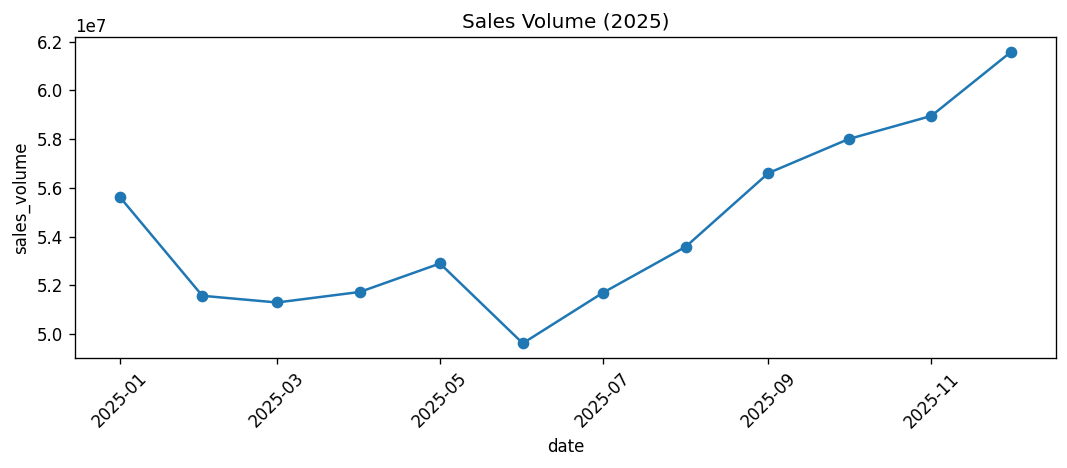

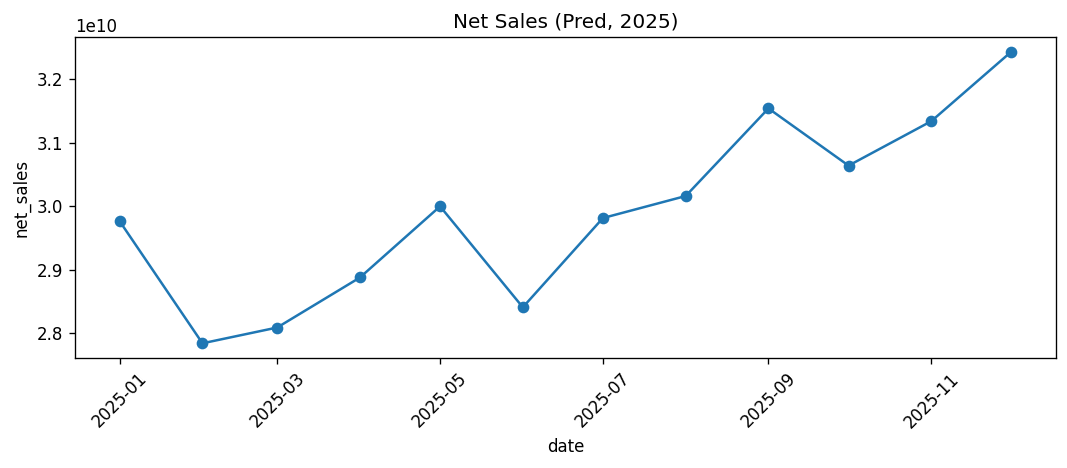

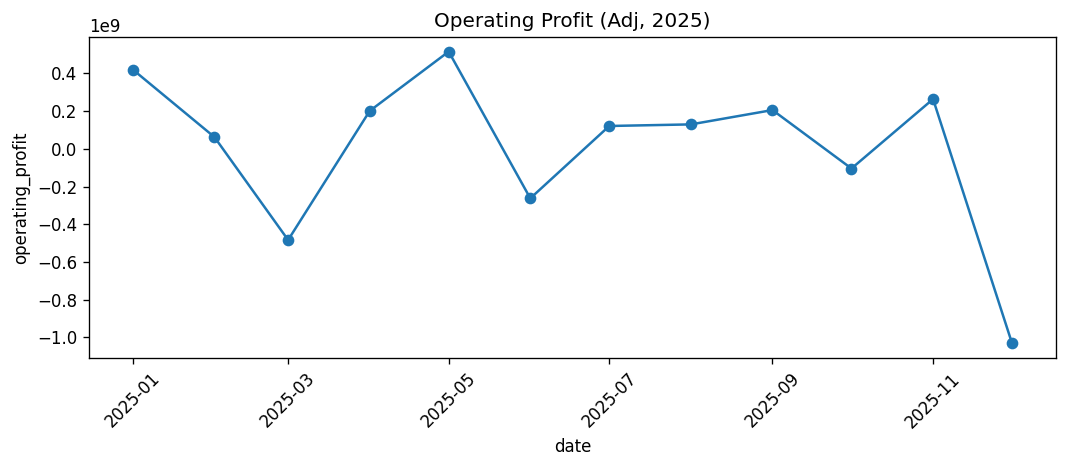

In [11]:
# 간단 플롯
def save_line(df, x, y, title, path):
    plt.figure(figsize=(9,4)); plt.plot(df[x], df[y], marker="o")
    plt.title(title); plt.xlabel("date"); plt.ylabel(y)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m")); plt.xticks(rotation=45); plt.tight_layout()
    plt.savefig(pjoin(path), bbox_inches="tight"); plt.show(); plt.close()

df_sum = pd.read_csv(pjoin("월별_통합_결과.csv"), encoding=CSV_ENCODING); df_sum["date"] = pd.to_datetime(df_sum["date"])
save_line(df_sum, "date", "sales_volume", "Sales Volume (2025)", "plot_sales_volume.png")
save_line(df_sum, "date", "net_sales",    "Net Sales (Pred, 2025)", "plot_net_sales.png")
save_line(df_sum, "date", "operating_profit", "Operating Profit (Adj, 2025)", "plot_operating_profit.png")

In [12]:
# Metadata
metadata = {
    "schema_version": "5.1-total+share-patch",
    "generated_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "notes": "Patched log-share using numeric coercion; robust compute_lc_share"
}
with open(pjoin("metadata.json"), "w", encoding="utf-8") as f: json.dump(metadata, f, ensure_ascii=False, indent=2)
print("All done.")

All done.
